Script for clustering simulated sequences using the Hamming distance metric

In [1]:
import numpy as np
import zarr
import allel
import scipy.cluster.hierarchy as sch
import scipy.spatial
import matplotlib
import matplotlib.pyplot as plt
import scipy.signal
from scipy.ndimage.filters import gaussian_filter1d
from numpy.lib.stride_tricks import sliding_window_view
from tqdm import tqdm
import dask
from dask import compute, delayed
from itertools import combinations
import time
import seaborn as sns
import sys

In [2]:


seed = sys.argv[1]

#This code is taken from Anushka Thawani. Adaptations were made outside of this script, 
#but was mostly in shell script on the HPC, which cannot be represented, for example the module sys.
def convert(file, genome):
    
    '''
    This function extracts haplotypes sequences from a vcf file 
    Adapted from: http://alimanfoo.github.io/2018/04/09/selecting-variants.html
    
    Arguments:
        file: name of vcf file (from SLiM soft sweep simulation)
        genome: length of genome used in SLiM simulation 
        
    Returns:
        ht: haplotype sequences for 200 individuals
        samp_freq: frequency of sweep mutation in sample
        cols: used to color dendrogram

    '''
    
    v = file + '.vcf'
    z = file + '.zarr'

    slim_sim_data = allel.read_vcf(v, fields='*')
    allel.vcf_to_zarr(v, z, fields='*', overwrite=True)

    data = zarr.open_group(z, mode='r')
    pos = allel.SortedIndex(data['variants/POS'])
    
    gt = data['calldata/GT'][:,0:100]
    ht = allel.GenotypeArray(gt).to_haplotypes()
    
    mutation = int((genome+1)/2) + 1
    
    contains_sweep = pos.locate_range(mutation,mutation)
    sweep = ht[contains_sweep]
    sweep = np.sum(sweep, axis =0)
    
    samp_freq = np.sum(sweep)/200
    
    cols = {}
    for i in range(200):
        if sweep[i]:
            cols[i] = 'r'
        else:
            cols[i] = "#808080"
    
    return ht, pos, samp_freq, cols, sweep

In [3]:
def distance(genome, haplotypes, pos,gts): 
    '''
    This function calculates the Hamming distances between all pairs of haplotype sequences.
    
    Arguments:
        genome: length of genome (in SLiM simulation)
        haplotypes: haplotype sequences from vcf file
    '''
    
    start  = 0
    end = genome
    region = pos.locate_range(start,end)  
        
    htx = haplotypes[region]
    d = allel.pairwise_distance(htx, metric="hamming")
    
    return d

In [4]:
def analysis(file, genome): 
    '''
    This function clusters the sequences stored in a .vcf file using Hamming distances.
    
    Arguments:
        file: name of vcf file
        genome: length of genome (in SLiM simulation)
    '''


    global mutation
    mutation = int((genome+1)/2) 
    n = 400 #number of haplotypes 
    gts = int((n*(n-1))/2)
    
    
    # Extract haplotype sequences from .vcf file
    ht, pos, samp_freq, cols, sweep = convert(file, genome)

    
    # Calculate Hamming distance between all pairs of haplotype sequences
    d = distance(genome, ht, pos, gts)
    
    
    # Clustering
    Z = sch.linkage(d, method = 'complete')
    
    
    # Plot dendrogram without colouring branches
    matplotlib.rcParams.update({'font.size': 24})
    fig = plt.figure(figsize=(30, 12))
    gs = matplotlib.gridspec.GridSpec(2, 1, hspace=0.1, wspace=1, height_ratios=(1,1))

    ax_dend = fig.add_subplot(gs[0, 0])
    sns.despine(ax=ax_dend, offset=5, bottom=True, top=True)
    dd = sch.dendrogram(Z,color_threshold=0,above_threshold_color='#808080',ax=ax_dend)

    ls = []
    for leaf, leaf_color in zip(plt.gca().get_xticklabels(), dd["leaves_color_list"]):
        leaf.set_color(cols[int(leaf.get_text())])
        ls.append(int(leaf.get_text()))

    ax_dend.set_ylabel('Haplotype age/generations',fontsize=24)
    ax_dend.set_title('Haplotype clusters',fontsize=24)
    
    
    # Plot dendrogram and colour branches
    ax_dend_2 = fig.add_subplot(gs[1, 0])
    
    dflt_col = "#808080"
    
    link_cols = {}
    for i, i12 in enumerate(Z[:,:2].astype(int)):
        c1, c2 = (link_cols[x] if x > len(Z) else cols[x] for x in i12)
        link_cols[i+1+len(Z)] = c1 if c1 == c2 else dflt_col

    sns.despine(ax=ax_dend_2, offset=5, bottom=True, top=True)
    dd = sch.dendrogram(Z,color_threshold=None,link_color_func=lambda x: link_cols[x],ax=ax_dend_2)

    ls = []
    for leaf, leaf_color in zip(plt.gca().get_xticklabels(), dd["leaves_color_list"]):
        leaf.set_color(cols[int(leaf.get_text())])
        ls.append(int(leaf.get_text()))

    ax_dend_2.set_ylabel('Haplotype age/generations',fontsize=24)
    
    
    output = 'control_' + file + '.pdf'
    plt.savefig(output)
    
    return 

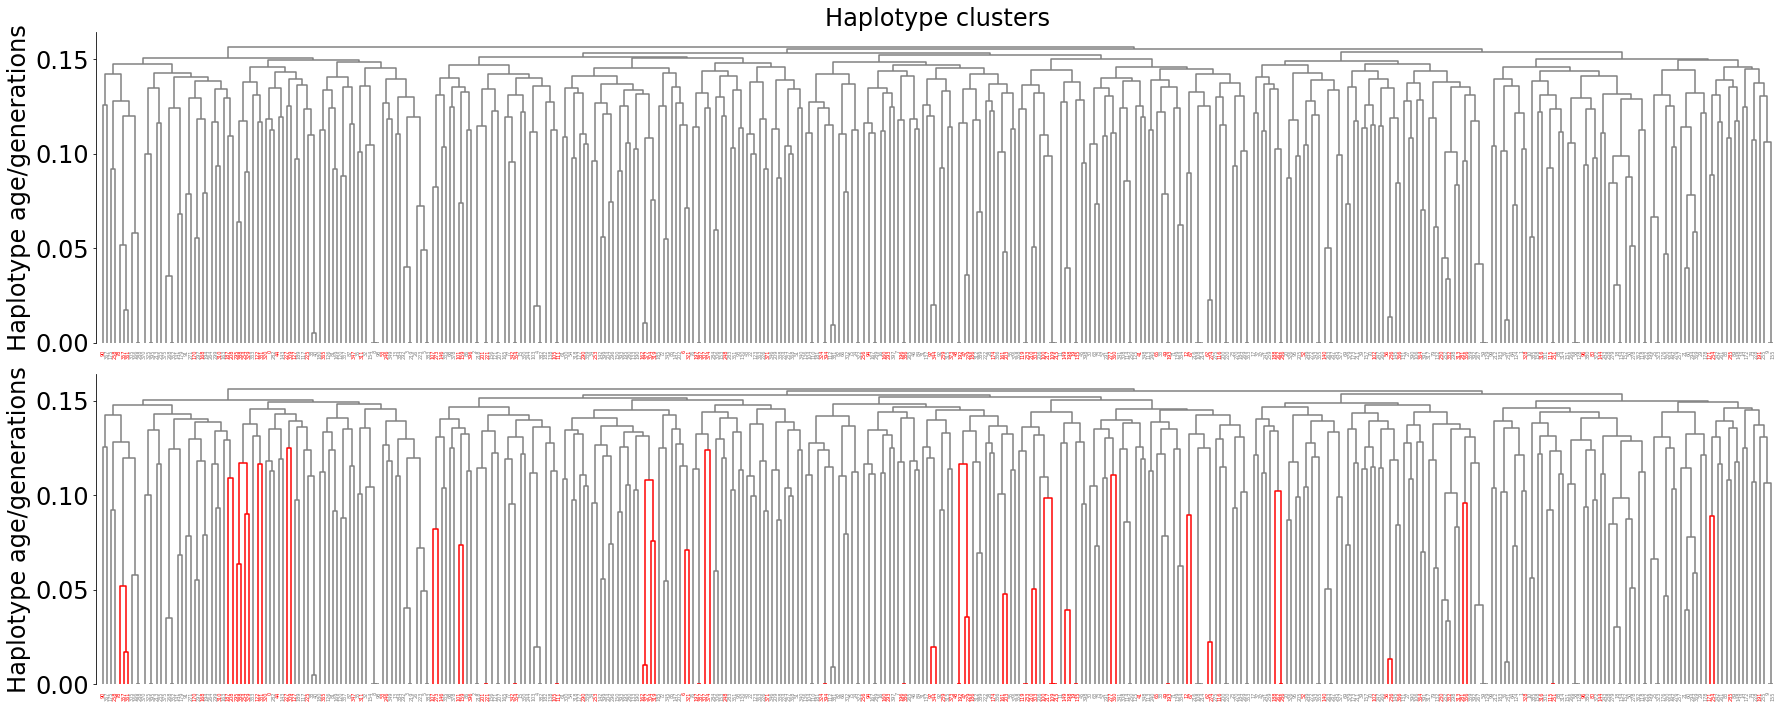

In [5]:
analysis(file='test_no.1_v2'+seed+'.pdf',genome=70000)

In [6]:
# analysis(['001_A',39999,1000])
# analysis(['001_B',39999,1000])
# analysis(['001_D',39999,1000])
# analysis(['001_E',39999,1000])

# analysis(['002_A',19999,1000])
# analysis(['002_B',19999,1000])
# analysis(['002_C',19999,1000])
# analysis(['002_D',19999,1000])
# analysis(['002_E',19999,1000])

# analysis(['003_A',9999,1000])
# analysis(['003_B',9999,1000])
# analysis(['003_C',9999,1000])
# analysis(['003_D',9999,1000])
# analysis(['003_E',9999,1000])

# analysis(['004_A',99999,1000])
# analysis(['004_B',99999,1000])
# analysis(['004_C',99999,1000])
# analysis(['004_D',99999,1000])
# analysis(['004_E',99999,1000])

# analysis(['005_A',99999,1000])
# analysis(['005_B',99999,1000])
# analysis(['005_C',99999,1000])
# analysis(['005_D',99999,1000])
# analysis(['005_E',99999,1000])

# analysis(['006_A',99999,1000])
# analysis(['006_B',99999,1000])
# analysis(['006_C',99999,1000])
# analysis(['006_D',99999,1000])
# analysis(['006_E',99999,1000])